# Importações

In [1]:
#!pip install scikit-learn shap pandas numpy matplotlib xgboost seaborn 

In [2]:
import pickle

import shap
import matplotlib.pyplot as plt

import pandas as pd 
import numpy as np  

# Pré-processamento e pipelines
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler

# Modelos de ML
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Validação e busca de hiperparâmetros
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform

# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

# Transformadores personalizados
from transformers import DateFeatureExtractor, CapTransformer, RareCategoryGrouper

c:\Users\hehe\Documents\GitHub\projeto-pisi3\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Carregando dataset

In [3]:
# Carregar o dataset
df = pd.read_csv('../data/filmes_filtrados.csv')

# Dividindo os dados
- X_train, X_test, y_train, y_test

In [4]:
numerical_cols = df[['popularity', 'budget', 'runtime']].columns
categorical_col = ['original_language']
date_column = 'release_date'

X = df.drop(columns=['vote_average'])
y = df['vote_average']

# Dividindo o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=87)

# Transformadores
- MultiLabelBinarize -> Generos Cinematográficos e Produtora
- Data -> Extrai o ano e o mês das datas
- Outliers -> Cap, Log + Cap, Winsorizer
- Agrupamento de categorias raras -> original language

### Colunas: Generos Cinematográficos e Produtora
Aplicando MultiLabelBinarize com limites de 12 e 10, respectivamente

In [5]:
def process_multilabel_column(train_series, test_series, sep='-', top_n=20, outros=True, prefix=''):
    # Extrair top N do treino
    exploded = train_series.str.split(sep).explode().str.strip()
    top = exploded.value_counts().nlargest(top_n).index

    def filter_top(vals):
        vals = [v.strip() for v in vals.split(sep)]
        if outros:
            return [v if v in top else 'Outros' for v in vals]
        else:
            return [v for v in vals if v in top]

    # Aplicar transformação
    train_processed = train_series.apply(filter_top)
    test_processed = test_series.apply(filter_top)

    mlb = MultiLabelBinarizer()
    train_encoded = pd.DataFrame(
        mlb.fit_transform(train_processed),
        columns=[f'{prefix}_{cls}' for cls in mlb.classes_],
        index=train_series.index
    )
    test_encoded = pd.DataFrame(
        mlb.transform(test_processed),
        columns=[f'{prefix}_{cls}' for cls in mlb.classes_],
        index=test_series.index
    )

    return train_encoded, test_encoded, mlb


#### Generos cinematográficos

In [6]:
teste = X_train['genres'].apply(lambda x: x.split('-')).copy()
teste = teste.explode().reset_index(drop=True)
genre_counts = teste.value_counts() # Apply value_counts directly to the Series
print(genre_counts)
print(len(genre_counts))

genres
Drama              3878
Comedy             2841
Thriller           2261
Action             2163
Romance            1426
Adventure          1396
Crime              1323
Horror             1316
Science Fiction     996
Fantasy             793
Family              770
Mystery             743
History             439
Animation           412
War                 342
Music               263
Western             141
Documentary         101
TV Movie             65
Name: count, dtype: int64
19


In [7]:
genres_train, genres_test, mlb_genres= process_multilabel_column(
    X_train['genres'], X_test['genres'], sep='-', top_n=12, outros=True, prefix='genre'
)

# Substituir a coluna original
X_train = X_train.drop(columns='genres').join(genres_train)
X_test = X_test.drop(columns='genres').join(genres_test)

##### Definindo Pickle

In [8]:
#with open('mlb_genres.pkl', 'wb') as f:
    #pickle.dump(mlb_genres, f)

#### Produtoras

In [9]:
teste = X_train['production_companies'].apply(lambda x: x.split('-')).copy()
teste = teste.explode().reset_index(drop=True)
production_counts = teste.value_counts() # Apply value_counts directly to the Series
print(production_counts[:8])
print(len(production_counts))

production_companies
Universal Pictures       516
Warner Bros. Pictures    500
20th Century Fox         376
Columbia Pictures        371
Paramount                371
Goldwyn                  264
Metro                    262
Mayer                    252
Name: count, dtype: int64
9944


In [10]:
production_train, production_test, mlb_production = process_multilabel_column(
    X_train['production_companies'], X_test['production_companies'], sep='-', top_n=8, outros=True, prefix='production'
)

# Substituir a coluna original
X_train = X_train.drop(columns='production_companies').join(production_train)
X_test = X_test.drop(columns='production_companies').join(production_test)

##### Definindo pickle 

In [11]:
#with open('mlb_production.pkl', 'wb') as f:
    #pickle.dump(mlb_production, f)

# Treinamento
- Modelo XGBRegressor
- Modelo SVR
- Modelo RandomForest

### Definindo Kf

In [12]:
# Definindo o KFold para o cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=87)

### XGBRegressor

In [13]:
# Cap de outliers + padronização
num_pipeline = Pipeline([
    ('cap', CapTransformer(columns=numerical_cols)),
    ('scale', StandardScaler())
])


# OneHot para variáveis categóricas
cat_pipeline = Pipeline([
    ('rare', RareCategoryGrouper(column='original_language', top_n=10, other_label='Other')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pré-processador geral
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_col)
], remainder='passthrough')  # passa as colunas de ano/mês e binarizadas


# Pipeline Completo
pipeline = Pipeline([
    ('date', DateFeatureExtractor(date_column=date_column)),  # extrai year e month
    ('preprocess', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=87, n_jobs=-1))
])

# RandomizedSearch
param_dist = {
    'regressor__n_estimators': randint(100, 300),
    'regressor__max_depth': randint(3, 10),
    'regressor__learning_rate': uniform(0.01, 0.3),
    'regressor__subsample': uniform(0.7, 0.3),
    'regressor__colsample_bytree': uniform(0.7, 0.3),
}

kf = KFold(n_splits=5, shuffle=True, random_state=87)

XGBRegressor_rand = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=kf,
    scoring='r2',
    random_state=87,
    verbose=2,
    n_jobs=-1
)

# Treinamento e resultado
XGBRegressor_rand.fit(X_train, y_train)

print("Melhores parâmetros:", XGBRegressor_rand.best_params_)
print("Melhor R² (validação cruzada):", XGBRegressor_rand.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhores parâmetros: {'regressor__colsample_bytree': np.float64(0.8696231377727208), 'regressor__learning_rate': np.float64(0.05992056035524427), 'regressor__max_depth': 5, 'regressor__n_estimators': 241, 'regressor__subsample': np.float64(0.8173221947525602)}
Melhor R² (validação cruzada): 0.4861070269728551


### SVR

In [14]:
# Pipeline para numéricas com cap e padronização
num_pipeline = Pipeline([
    ('cap', CapTransformer(columns=numerical_cols)),
    ('scale', StandardScaler())
])


# Pipeline para categóricas com OneHot
cat_pipeline = Pipeline([
    ('rare', RareCategoryGrouper(column='original_language', top_n=10, other_label='Other')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# ColumnTransformer para combinar tudo
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_col)
], remainder='passthrough')  # mantém as colunas como 'year', 'month', e as multilabel binarizadas


pipeline = Pipeline([
    ('date', DateFeatureExtractor(date_column=date_column)),  # extrai 'year' e 'month'
    ('preprocess', preprocessor),
    ('regressor', SVR())
])

param_dist = {
    'regressor__kernel': ['rbf', 'linear'],
    'regressor__C': loguniform(1e-2, 1e2),
    'regressor__epsilon': uniform(0.01, 0.3),
    'regressor__gamma': ['scale', 'auto']
}


svm_rand = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=20,  
    cv=kf,
    scoring='r2',
    random_state=87,
    verbose=2,
    n_jobs=-1
)

svm_rand.fit(X_train, y_train)

print("Melhores parâmetros:", svm_rand.best_params_)
print("Melhor R² (validação cruzada):", svm_rand.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores parâmetros: {'regressor__C': np.float64(4.217516020234043), 'regressor__epsilon': np.float64(0.29647041307396826), 'regressor__gamma': 'auto', 'regressor__kernel': 'rbf'}
Melhor R² (validação cruzada): 0.4395249234365182


### RandomForest

In [15]:
num_pipeline = Pipeline([
    ('cap', CapTransformer(columns=numerical_cols)),
    ('scale', StandardScaler())
])



preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_col)
], remainder='passthrough')


# --- Pipeline final com RandomForest ---
pipeline_rf = Pipeline([
    ('date', DateFeatureExtractor(date_column=date_column)),
    ('preprocess', preprocessor),
    ('regressor', RandomForestRegressor(random_state=87, n_jobs=-1))
])


# --- Espaço de busca para RandomizedSearchCV ---
param_dist_rf = {
    'regressor__n_estimators': randint(100, 500),
    'regressor__max_depth': randint(3, 20),
    'regressor__min_samples_split': randint(2, 10),
    'regressor__min_samples_leaf': randint(1, 10),
    'regressor__max_features': ['sqrt', 'log2', None]
}

rf_rand = RandomizedSearchCV(
    estimator=pipeline_rf,
    param_distributions=param_dist_rf,
    n_iter=30,
    cv=kf,
    scoring='r2',
    error_score='raise',     
    random_state=87,
    verbose=2,
    n_jobs=-1
)

# --- Treino e outputs ---
rf_rand.fit(X_train, y_train)

print("Melhores parâmetros RF:", rf_rand.best_params_)
print("Melhor R² (CV) RF:", rf_rand.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhores parâmetros RF: {'regressor__max_depth': 14, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 430}
Melhor R² (CV) RF: 0.4632307992432885


# Gerando modelos Treinados

In [16]:
'''
with open('xgb_pipeline.pkl', 'wb') as f:
    pickle.dump(XGBRegressor_rand, f)

with open('svr_pipeline.pkl', 'wb') as f:
    pickle.dump(svm_rand, f)

with open('rf_pipeline.pkl', 'wb') as f:
    pickle.dump(rf_rand, f)
'''

"\nwith open('xgb_pipeline.pkl', 'wb') as f:\n    pickle.dump(XGBRegressor_rand, f)\n\nwith open('svr_pipeline.pkl', 'wb') as f:\n    pickle.dump(svm_rand, f)\n\nwith open('rf_pipeline.pkl', 'wb') as f:\n    pickle.dump(rf_rand, f)\n"

# Avaliação dos modelos

In [17]:
def evaluate_model(model_name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'Modelo': model_name,
        'R²': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MedAE': median_absolute_error(y_test, y_pred)
    }


In [18]:
results = []

results.append(evaluate_model("XGBRegressor", XGBRegressor_rand.best_estimator_, X_test, y_test))
results.append(evaluate_model("SVR", svm_rand.best_estimator_, X_test, y_test))
results.append(evaluate_model("RandomForestRegressor", rf_rand.best_estimator_, X_test, y_test))

results_df = pd.DataFrame(results)
print(results_df)

                  Modelo        R²       MAE      RMSE     MedAE
0           XGBRegressor  0.509629  0.484806  0.639296  0.386420
1                    SVR  0.450195  0.508508  0.676930  0.393708
2  RandomForestRegressor  0.476488  0.502198  0.660546  0.415460


# Gráficos

In [19]:
# Erro de importação do SHAP com o numpy 

#!pip uninstall numpy
#!pip install numpy==1.22.4 

                    feature  importance
21             genre_Horror    0.103740
18              genre_Drama    0.100253
23             genre_Outros    0.086669
2                   runtime    0.082980
5      original_language_en    0.073261
14             genre_Action    0.043799
0                popularity    0.042659
25    genre_Science Fiction    0.035877
36                     year    0.031987
3   original_language_Other    0.028082


 99%|===================| 8411/8472 [00:57<00:00]        

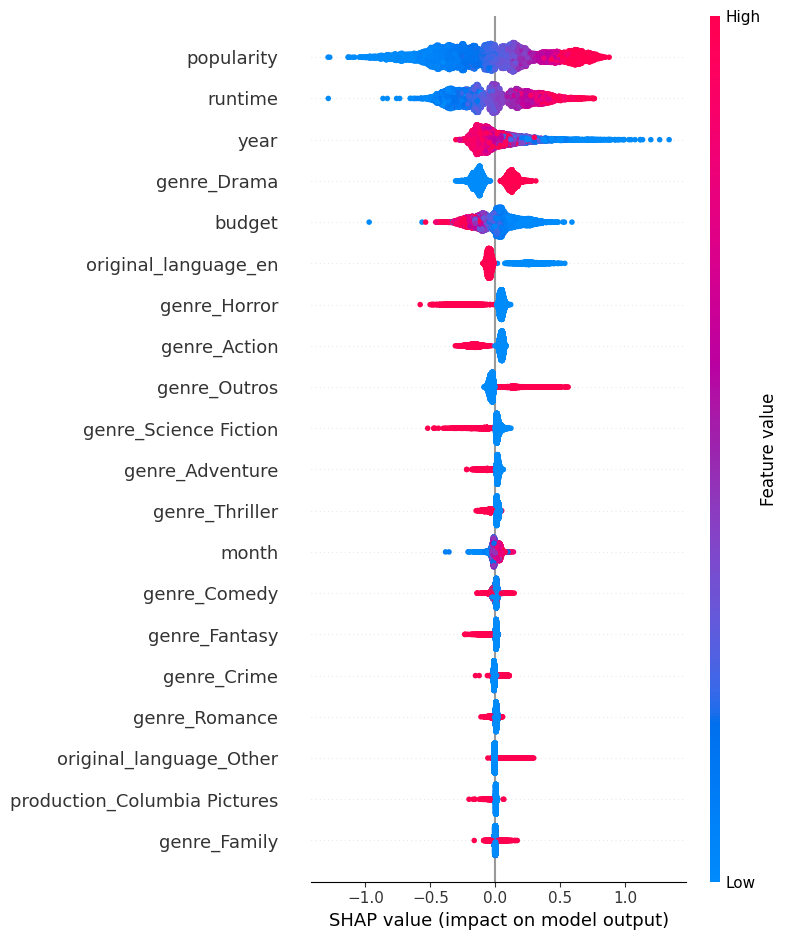

In [20]:
# Extrair o modelo XGBRegressor treinado do pipeline
xgb_model = XGBRegressor_rand.best_estimator_.named_steps['regressor']

# Extrair as features após o processamento
# Precisamos transformar X_train para obter as features corretas
X_train_transformed = XGBRegressor_rand.best_estimator_.named_steps['preprocess'].transform(
    XGBRegressor_rand.best_estimator_.named_steps['date'].transform(X_train)
)

# Obter os nomes das features após o ColumnTransformer
feature_names = []
# num_pipeline features
feature_names += list(numerical_cols)
# cat_pipeline features
cat_features = X_train[categorical_col[0]].unique()
cat_feature_names = XGBRegressor_rand.best_estimator_.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_col)
feature_names += list(cat_feature_names)
# remainder (multilabels, year, month)
remainder = [col for col in X_train.columns if col not in numerical_cols and col not in categorical_col and col != date_column]
feature_names += remainder + ['year', 'month']

# Feature importances do XGBoost
importances = xgb_model.feature_importances_

# Exibir as 10 features mais importantes
importances_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
print(importances_df.sort_values('importance', ascending=False).head(10))

# SHAP
explainer = shap.Explainer(xgb_model, X_train_transformed, feature_names=feature_names)
shap_values = explainer(X_train_transformed)

# Resumo SHAP
shap.summary_plot(shap_values, features=X_train_transformed, feature_names=feature_names)

In [21]:
pd.set_option('display.max_rows', None)
display(importances_df.sort_values('importance', ascending=False))
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

,feature,importance
21,genre_Horror,0.103740
18,genre_Drama,0.100253
23,genre_Outros,0.086669
2,runtime,0.082980
5,original_language_en,0.073261
14,genre_Action,0.043799
0,popularity,0.042659
25,genre_Science Fiction,0.035877
36,year,0.031987
3,original_language_Other,0.028082
